# Ejercicio 2 - Breast Cancer Wisconsin

# ETL

In [128]:
%pip install pandas openpyxl numpy matplotlib seaborn

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: C:\Users\juan.gaviria\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [129]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier

In [130]:
df = pd.read_csv('./data-breast-cancer.csv')

print(df.shape)

(569, 33)


In [131]:
df.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


In [132]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 33 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       569 non-null    int64  
 1   diagnosis                569 non-null    object 
 2   radius_mean              569 non-null    float64
 3   texture_mean             569 non-null    float64
 4   perimeter_mean           569 non-null    float64
 5   area_mean                569 non-null    float64
 6   smoothness_mean          569 non-null    float64
 7   compactness_mean         569 non-null    float64
 8   concavity_mean           569 non-null    float64
 9   concave points_mean      569 non-null    float64
 10  symmetry_mean            569 non-null    float64
 11  fractal_dimension_mean   569 non-null    float64
 12  radius_se                569 non-null    float64
 13  texture_se               569 non-null    float64
 14  perimeter_se             5

In [133]:
# Eliminar columnas innecesarias
df = df.drop(columns=['id'])
df = df.drop(columns=['Unnamed: 32'])


In [134]:
print(df['diagnosis'].unique())

# Mapear la columna 'diagnosis' a valores numéricos
df['diagnosis'] = df['diagnosis'].map({'M': 1, 'B': 0})

['M' 'B']


In [135]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   diagnosis                569 non-null    int64  
 1   radius_mean              569 non-null    float64
 2   texture_mean             569 non-null    float64
 3   perimeter_mean           569 non-null    float64
 4   area_mean                569 non-null    float64
 5   smoothness_mean          569 non-null    float64
 6   compactness_mean         569 non-null    float64
 7   concavity_mean           569 non-null    float64
 8   concave points_mean      569 non-null    float64
 9   symmetry_mean            569 non-null    float64
 10  fractal_dimension_mean   569 non-null    float64
 11  radius_se                569 non-null    float64
 12  texture_se               569 non-null    float64
 13  perimeter_se             569 non-null    float64
 14  area_se                  5

In [136]:
print("Nulos: ", df.isnull().sum().sum())  # total de nulos
print("Duplicados: ", df.duplicated().sum())    # duplicados

Nulos:  0
Duplicados:  0


# Analisis

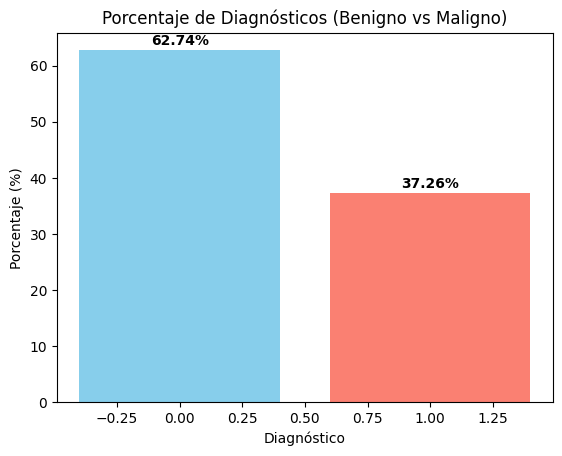

In [137]:
# Obtener porcentajes
percentages = df['diagnosis'].value_counts(normalize=True) * 100

# Crear gráfico de barras
plt.bar(percentages.index, percentages.values, color=['skyblue', 'salmon'])
plt.title('Porcentaje de Diagnósticos (Benigno vs Maligno)')
plt.xlabel('Diagnóstico')
plt.ylabel('Porcentaje (%)')

# Agregar etiquetas con los valores porcentuales
for i, v in enumerate(percentages.values):
    plt.text(i, v + 1, f"{v:.2f}%", ha='center', fontweight='bold')

plt.show()


### Descubrimos

- Desbalance moderado: la clase mayoritaria representa ~63% y la minoritaria ~37%. No es extremo (ej. 95/5), pero sí suficientemente asimétrico como para que merezca atención.

### ¿Por qué esto importa para modelado?

- Si un modelo predice siempre la clase mayoritaria (0), lograría ~63% de accuracy sin aprender nada útil. Por eso accuracy sola es insuficiente.
- Si no mantienes la proporción de clases al dividir en train/test, puedes introducir sesgo en la evaluación.
- Algunos clasificadores no manejan bien desbalances sin ajustes (KNN, SVM estándar), mientras que Decision Trees o Random Forest suelen ser más robustos.

### ¿Qué hacer?
- Usar particionado estratificado `train_test_split(..., stratify=y)`, mantiene la misma proporción de clases en cada partición, evitando evaluaciones optimistas/pesimistas.
- Elegir métricas adecuadas, No usar solo accuracy.
    - Recall (sensibilidad) para la clase positiva — captura cuántos malignos detectas.
    - Precision — cuántas de tus predicciones positivas son realmente malignas.
- Ajuste de pesos `class_weight='balanced'`, penaliza más los errores en la clase minoritaria durante el entrenamiento, ayudando al modelo a prestar más atención a ella.

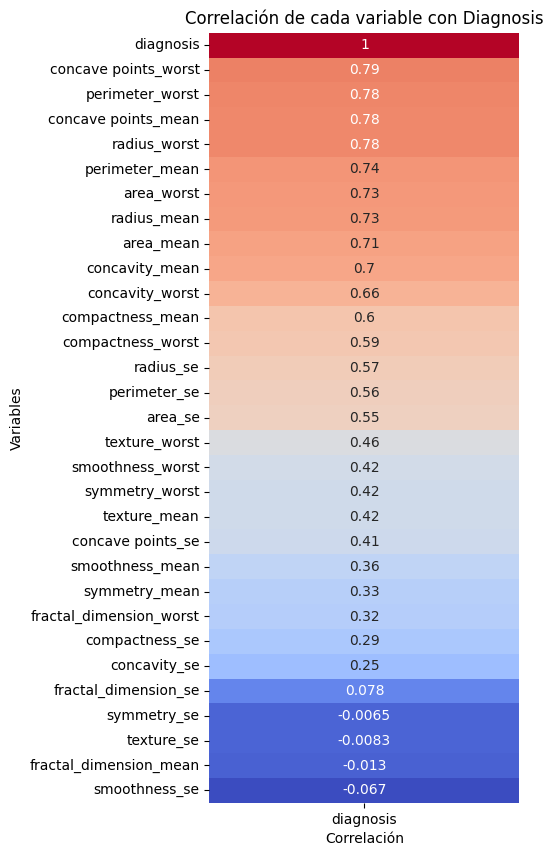

In [138]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calcular correlación con diagnosis
corr = df.corr()['diagnosis'].sort_values(ascending=False)

# Crear el heatmap
plt.figure(figsize=(4, 10))
sns.heatmap(corr.to_frame(), annot=True, cmap='coolwarm', cbar=False)
plt.title('Correlación de cada variable con Diagnosis', fontsize=12)
plt.ylabel('Variables')
plt.xlabel('Correlación')
plt.show()


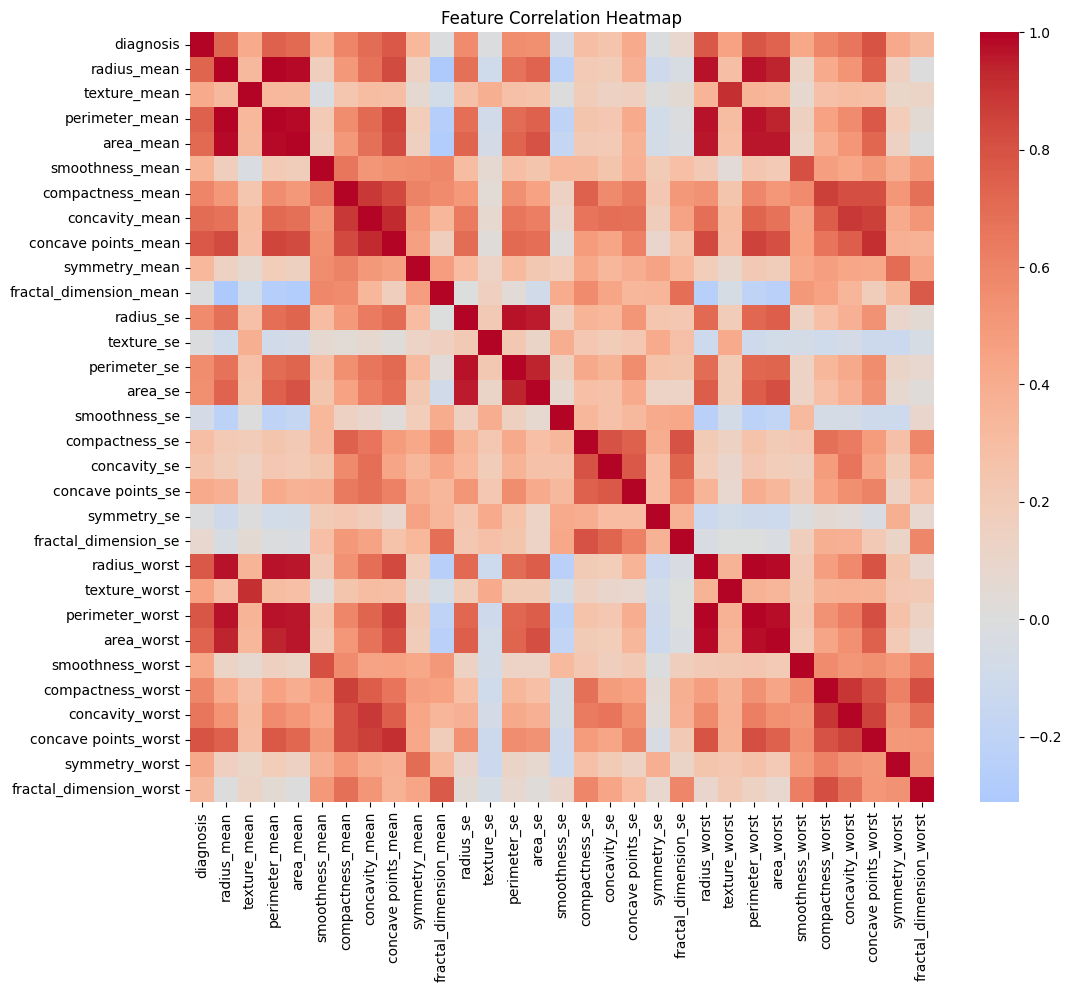

In [139]:
plt.figure(figsize=(12,10))
sns.heatmap(df.corr(), cmap='coolwarm', center=0)
plt.title("Feature Correlation Heatmap")
plt.show()


### Descubrimos

- Existen grupos de variables altamente correlacionadas entre sí, especialmente organizadas en tres bloques principales:
    - _mean → valores promedio de cada característica.
    - _se → errores estándar (variabilidad local).
    - _worst → valores máximos o más extremos.
- Este patrón revela una fuerte multicolinealidad, es decir, varias variables aportan información muy similar o redundante al modelo.
- Aunque el dataset contiene 30 variables, la información verdaderamente independiente se concentra en un número mucho menor de “factores” o componentes principales.

### ¿Por qué esto importa para modelado?

En modelos lineales como regresión logística o SVM lineal:
- Los coeficientes pueden volverse inestables.
- Pequeños cambios en los datos pueden alterar los pesos asignados a variables correlacionadas.
- El modelo puede tener dificultad para generalizar.
- la multicolinealidad distorsiona el aprendizaje y la interpretación de los modelos lineales (Logistic Regresion, SVM), aunque no afecta tanto a los modelos basados en árboles como Random Forest.

### Qué hacer?
- Usar L1 (Lasso) o ElasticNet, estas técnicas reducen o eliminan los coeficientes de variables redundantes, mejorando la estabilidad y la interpretabilidad del modelo.
- Aplicar reduccion de dimensionalidad PCA, permite condensar la información en menos componentes no correlacionadas, eliminando redundancia y facilitando el trabajo de modelos sensibles a la colinealidad.
- Preferir modelos robustos a redundancia como RandomForest o XGBoost

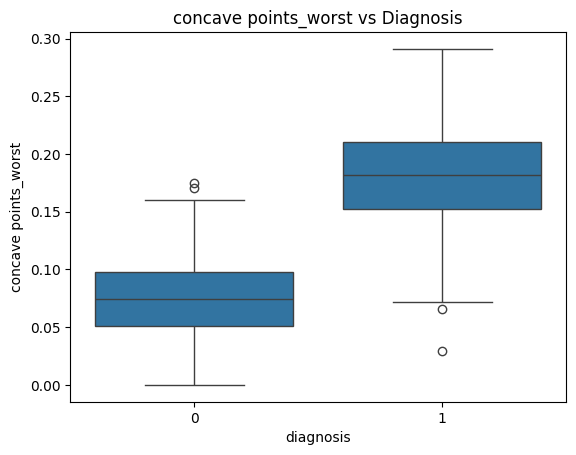

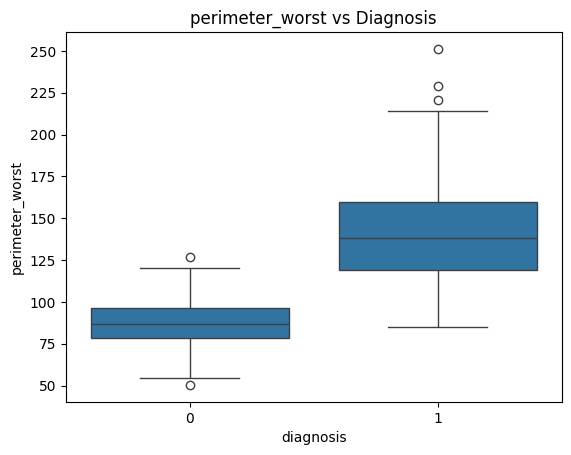

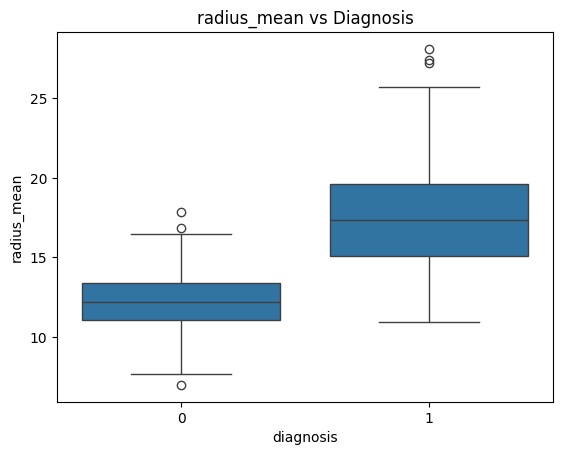

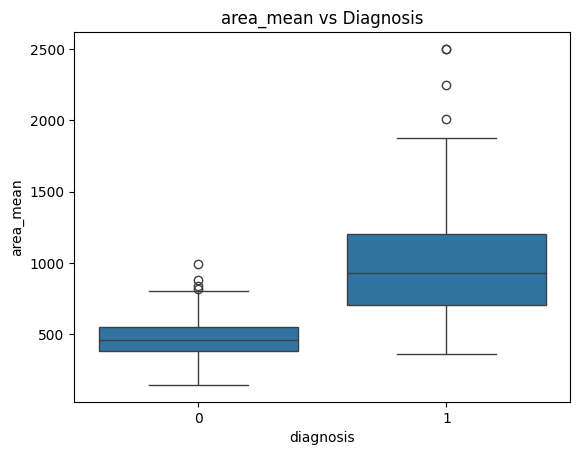

In [140]:
# Boxplots de las características más correlacionadas con el diagnóstico
top_features = ['concave points_worst', 'perimeter_worst', 'radius_mean', 'area_mean']

for feat in top_features:
    sns.boxplot(x='diagnosis', y=feat, data=df)
    plt.title(f'{feat} vs Diagnosis')
    plt.show()


### Descubrimos

- Las cajas muestran separación clara entre clases, indicando buena diferenciación entre tumores benignos y malignos.
- Los whiskers se superponen, lo que revela casos frontera o leves relaciones no lineales.

### ¿Por qué esto importa para modelado?

- Los datos son casi linealmente separables, por lo que modelos lineales (como Regresión Logística) funcionarán bien.
- La ligera superposición sugiere que modelos no lineales (SVM con RBF, RandomForest) podrían mejorar el rendimiento.

### Qué hacer?
- Aplicar regularización (L1 o ElasticNet) para estabilizar los coeficientes.
- Probar modelos no lineales para capturar la curvatura en los límites.
- Aplicar reduccion de dimensionalidad PCA, permite condensar la información en menos componentes.

# PCA

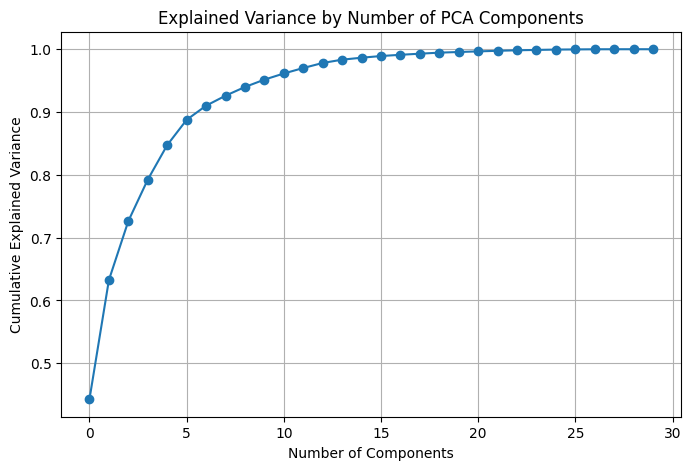

In [141]:
X = df.drop('diagnosis', axis=1)
y = df['diagnosis']

# Estandarización
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# PCA with all components
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

# Plot explained variance ratio
plt.figure(figsize=(8,5))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by Number of PCA Components')
plt.grid(True)
plt.show()


- Identificamos que con apartir de 10 componentes ya representamos el 95% de la muestra. 

In [142]:
# Keep 10 components (or whatever number your plot suggests)
pca = PCA(n_components=10)
X_reduced = pca.fit_transform(X_scaled)

print(f"Reduced shape: {X_reduced.shape}")


Reduced shape: (569, 10)


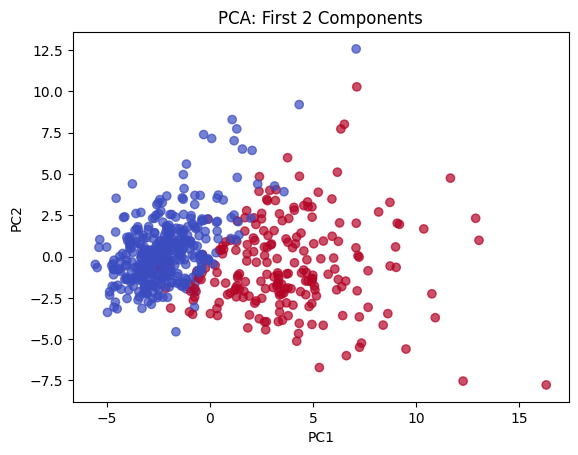

In [143]:
pca_result = pca.fit_transform(X_scaled)

plt.scatter(pca_result[:,0], pca_result[:,1], c=y, cmap='coolwarm', alpha=0.7)
plt.title('PCA: First 2 Components')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

Vemos que las clases (colores) se separan claramente, significa que:
- La mayoría de la información relevante se concentra en esos primeros componentes PC1 y PC2.
- El PCA logró representar el dataset de forma más compacta y entendible.

Recordemos que algunos modelos (como regresión logística sin regularización o SVM lineal) pueden verse afectados por la multicolinealidad, por eso aplicamos PCA.

Aplicar PCA te permite condensar la información esencial del dataset en menos variables, evitando redundancia y ruido, mientras mantienes casi el mismo poder predictivo.

El PCA reduce el overfitting porque obliga al modelo a aprender solo las direcciones de variación más relevantes de los datos, descartando ruido y redundancia, y reduciendo la complejidad del espacio de decisión

# Modelo

## Regresion Logistica

In [152]:
# Separar features y target
X = df.drop('diagnosis', axis=1)
y = df['diagnosis']

# Definir pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),             # Estandariza los datos
    ('pca', PCA(n_components=10)),            # Mantiene 10 componentes (≈95% varianza)
    ('logreg', LogisticRegression(
        penalty='l1', 
        solver='liblinear', 
        class_weight='balanced', 
        random_state=42
    ))
])

# Validación cruzada estratificada (preserva proporción de clases)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Evaluar rendimiento con ROC-AUC
scores = cross_val_score(pipeline, X, y, cv=cv, scoring='roc_auc')

print(f"Mean ROC-AUC with PCA + L1 Logistic Regression: {scores.mean():.4f} (+/- {scores.std():.4f})")

# Evaluar rendimiento con F1-score
scores = cross_val_score(pipeline, X, y, cv=cv, scoring='f1')

print(f"Mean F1-score with PCA + L1 Logistic Regression: {scores.mean():.4f} (+/- {scores.std():.4f})")

Mean ROC-AUC with PCA + L1 Logistic Regression: 0.9937 (+/- 0.0063)
Mean F1-score with PCA + L1 Logistic Regression: 0.9561 (+/- 0.0164)


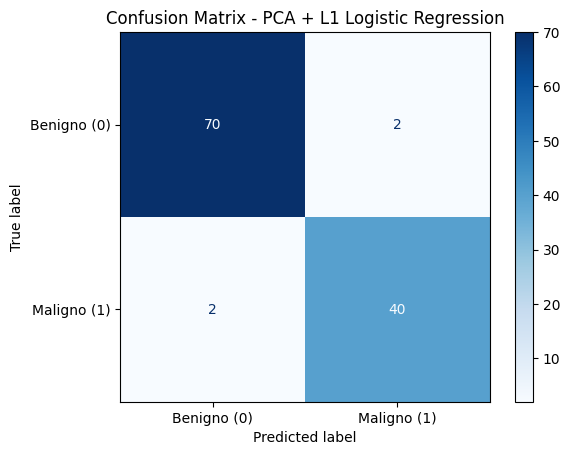

In [145]:
# Dividir datos en train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Entrenar pipeline completo
pipeline.fit(X_train, y_train)

# Predicciones
y_pred = pipeline.predict(X_test)

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Benigno (0)', 'Maligno (1)'])
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix - PCA + L1 Logistic Regression")
plt.show()


## Random forest

In [156]:
# Separar features y target
X = df.drop('diagnosis', axis=1)
y = df['diagnosis']

# Definir pipeline con PCA + Random Forest
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=10)),
    ('rf', RandomForestClassifier(
        n_estimators=200,           # número de árboles
        max_depth=None,             # sin límite de profundidad
        class_weight='balanced',    # balancea las clases
        random_state=42,
        n_jobs=-1                   # usa todos los núcleos para acelerar
    ))
])

# Validación cruzada
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Evaluar rendimiento con ROC-AUC
scores = cross_val_score(pipeline, X, y, cv=cv, scoring='roc_auc')

print(f"Mean ROC-AUC with PCA + Random Forest: {scores.mean():.4f} (+/- {scores.std():.4f})")

# Evaluar rendimiento con F1-score
scores = cross_val_score(pipeline, X, y, cv=cv, scoring='f1')

print(f"Mean F1-score with PCA + Random Forest: {scores.mean():.4f} (+/- {scores.std():.4f})")

Mean ROC-AUC with PCA + Random Forest: 0.9893 (+/- 0.0084)
Mean F1-score with PCA + Random Forest: 0.9403 (+/- 0.0274)


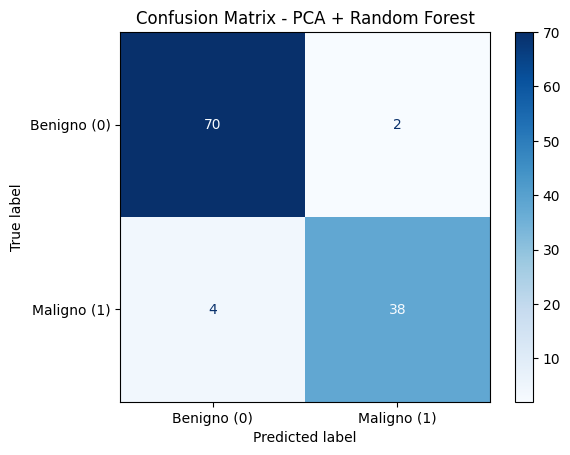

In [157]:
# Dividir datos en train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Entrenar pipeline
pipeline.fit(X_train, y_train)

# Predicciones
y_pred = pipeline.predict(X_test)

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Benigno (0)', 'Maligno (1)'])
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix - PCA + Random Forest")
plt.show()